https://desi.lbl.gov/trac/wiki/MilkyWayWG/PipelineOutputs

In [300]:
pwd

'/global/cfs/cdirs/desi/users/apcooper/projects/quicksv1'

In [59]:
import numpy as np
import glob
import os
import sys
import re
import subprocess
import fitsio
import healpy as hp
import warnings

from astropy.io import fits
from astropy.table import Table
import astropy.coordinates as coords
import astropy.units as u

import matplotlib.pyplot as pl
%matplotlib inline

In [10]:
from desitarget.sv1.sv1_targetmask import desi_mask, mws_mask, bgs_mask

In [11]:
import desi_retriever

In [12]:
class MWSData():
    
    MWS_REDUX_DIR = '/global/cfs/cdirs/desi/science/mws/redux/'
    
    def __init__(self,redux='blanc',procdate=210112):
        """
        """
        self.redux_dirname = redux
        
        # Special cases
        if redux == 'sv_daily':
            self.redux = 'daily'
        else:
            self.redux = redux
        
        self.date = str(procdate)
        self.load_tables()   
        return
    
    def __repr__(self):
        return '{}-{}'.format(redux,coadd)
    
    def __getitem__(self,key):
        return self.fm[key]
    
    def rvtab_path(self):
        """
        """
        base = 'rvtab_spectra-{}.fits'.format(self.redux)
        return os.path.join(self.MWS_REDUX_DIR,self.redux_dirname,'rv_output',self.date,base)
    
    def load_tables(self):
        # Load tables
        self.fm = Table.read(self.mwtab_path(),'FIBERMAP')   
        try:
            self.rv = Table.read(self.mwtab_path(),'SPRVTAB ')    
        except KeyError:
            self.rv = Table.read(self.mwtab_path(),'RVTAB ')   

In [13]:
class MWSExposures(MWSData):
    """
    Single exposures.
    
    Example:
        d = MWSExposures(redux='sv_daily', procdate=210110)
    """
    def __repr__(self):
        return 'MWS: {}-exp-{} ({})'.format(self.redux, self.date, self.mwtab_path())
    
    def mwtab_path(self):
        """
        For single exposures there is no combined table, yet
        """
        return self.rvtab_path()
    
    def fetch_spec_for_targetid(self,targetid,iexp=0,with_model=True):
        """
        """
        i = np.flatnonzero(self['TARGETID'] == targetid)[iexp]
        
        tileid = self.fm['TILEID'][i]
        night = self.fm['NIGHT'][i]
        fiber = self.fm['FIBER'][i]
            
        D = desi_retriever.andes.fetcher.get_specs(tileid=tileid,
                                               night=night,
                                               fiber=fiber,
                                               targetid=targetid,
                                               coadd=False,
                                               dataset=self.redux)
        return D

In [14]:
class MWSCoadd(MWSData):
    """
    Coadds are by tile, either:
        - nightly
        - all
        - deep
    
    Not all tiles have all coadd types.
    
    Example:
         # Read blanc coadds for all exposures
         MWSCoadd(coadd='all') 
    """
    def __init__(self,redux='blanc',coadd='all'):
        assert(coadd is not None)
        self.coadd = coadd
        super().__init__(redux)
            
    def __repr__(self):
        return 'MWS: {}-{} ({})'.format(self.redux,self.coadd, self.mwtab_path())
  
    def mwtab_path(self):
        """
        For the coadds, there is a 'master' table.
        """
        base = 'mwtab_coadd-{}-{}.fits'.format(self.redux,self.coadd)
        return os.path.join(self.MWS_REDUX_DIR,self.redux,base)
    
    def fetch_spec_for_targetid(self,targetid,night=None,with_model=True):
        """
        """
        i = np.flatnonzero(self['TARGETID'] == targetid)
        
        tileid = self.fm['TILEID'][i]
        fiber = self.fm['FIBER'][i]
        
        if self.coadd == 'nights':
            assert(night is not None)
            
        D = desi_retriever.andes.fetcher.get_specs(tileid=tileid,
                                               night=night,
                                               fiber=fiber,
                                               targetid=targetid,
                                               coadd=True,
                                               dataset=self.redux)
        return D

In [15]:
d = MWSExposures(redux='sv_daily',procdate=210110)
d

MWS: daily-exp-210110 (/global/cfs/cdirs/desi/science/mws/redux/sv_daily/rv_output/210110/rvtab_spectra-daily.fits)

The RV table is in d.rv and the 'fibermap' in d.fm (the fibermap columns can also be accessed directly throuhg d[]). If you don't want to use those objects just load the corresponding rv and fibermap tables and substitute below.

In [19]:
# Summary of target types
Table(np.unique(d['SV1_MWS_TARGET'],return_counts=True),names=[None,'Counts'])

SV1_MWS_TARGET,Counts
int64,int64
0,524734
4,241
17,123481
21,155
33,139391
37,215
49152,10544
49156,89
81920,14656


In [164]:
def spec_ok(rv,success='SUCCESS'):
    return (rv[success]) & (rv['SN_B'] > 2) & (rv['SN_R'] > 2) & (rv['SN_Z'] > 2) 

def mws_samples(d):
    """
    """
    pm = np.sqrt(d['PMRA']**2 + d['PMDEC']**2)

    gmag = 22.5 - 2.5 * np.log10(d['FLUX_G'].clip(1e-7))
    rmag = 22.5 - 2.5 * np.log10(d['FLUX_R'].clip(1e-7))
    zmag = 22.5 - 2.5 * np.log10(d['FLUX_Z'].clip(1e-7))

    gmr = gmag - rmag
    rmz = rmag - zmag
    
    is_mws_red = (rmag < 19) & (np.abs(pm) < np.log10(7)) & (np.isfinite(pm)) & (gmr > 0.7)
    is_mws_blue = (rmag < 19) & (gmr < 0.7)
    is_mws_broad = (rmag < 19) & ((np.abs(pm) >= np.log10(7)) | (~np.isfinite(pm))) & (gmr > 0.7)
    
    return is_mws_red,is_mws_blue,is_mws_broad

In [169]:
def plot_compare_mws_samples(prop,d,bins,decorate=None,density=False,success='SUCCESS'):
    """
    """
    is_mws_red,is_mws_blue,is_mws_broad = mws_samples(d)
    
    mws_sv_target = (d['SV1_MWS_TARGET'] > 0) & (d['SV1_MWS_TARGET'] != 999999)

    specok = spec_ok(d.rv,success=success)

    h_red,_ = np.histogram(prop[is_mws_red & specok],bins=bins,density=density)
    h_blue,_ = np.histogram(prop[is_mws_blue & specok],bins=bins,density=density)
    h_broad,_ = np.histogram(prop[is_mws_broad & specok],bins=bins,density=density)

    h_red_mw,_ = np.histogram(prop[is_mws_red & specok & mws_sv_target],bins=bins,density=density)
    h_blue_mw,_ = np.histogram(prop[is_mws_blue & specok & mws_sv_target],bins=bins,density=density)
    h_broad_mw,_ = np.histogram(prop[is_mws_broad & specok & mws_sv_target],bins=bins,density=density)
    
    pl.figure(figsize=(12,6))

    pl.subplot(121)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        pl.plot(bins[:-1],np.log10(h_red),drawstyle='steps-post',c='r',label='RED (all)')
        pl.plot(bins[:-1],np.log10(h_blue),drawstyle='steps-post',c='b',label='BLUE (all)')
        pl.plot(bins[:-1],np.log10(h_broad),drawstyle='steps-post',c='g',label='BROAD (all)')

    if decorate is not None:
        decorate()
    pl.title('All r < 19')
    
    pl.subplot(122)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        pl.plot(bins[:-1],np.log10(h_red_mw),drawstyle='steps-post',c='r',label='SV1 MWS targets')
        pl.plot(bins[:-1],np.log10(h_blue_mw),drawstyle='steps-post',c='b')
        pl.plot(bins[:-1],np.log10(h_broad_mw),drawstyle='steps-post',c='g')

    if decorate is not None:
        decorate()
    pl.title('MWS Targets only')

    return

In [166]:
# MWS Selection criteria
# (missing parallax: parallax error column doesn't get propagated through to spec files)

pm = np.sqrt(d['PMRA']**2 + d['PMDEC']**2)

gmag = 22.5 - 2.5 * np.log10(d['FLUX_G'].clip(1e-7))
rmag = 22.5 - 2.5 * np.log10(d['FLUX_R'].clip(1e-7))
zmag = 22.5 - 2.5 * np.log10(d['FLUX_Z'].clip(1e-7))

gmr = gmag - rmag
rmz = rmag - zmag

Everything...

<ipython-input-167-b07e69b351b4>:1: RuntimeWarning: divide by zero encountered in log10
  pl.hexbin(gmr,np.log10(np.abs(pm)),bins='log',extent=(-1,2.5,-2,3),gridsize=200)#,s=1,alpha=0.1)


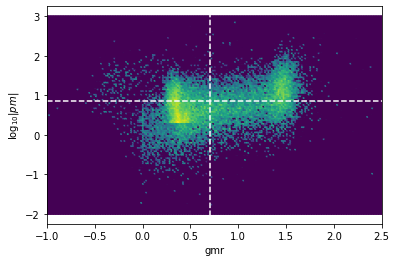

In [167]:
pl.hexbin(gmr,np.log10(np.abs(pm)),bins='log',extent=(-1,2.5,-2,3),gridsize=200)#,s=1,alpha=0.1)
pl.xlim(-1,2.5)
pl.xlabel('gmr')
pl.ylabel('$\log_{10}|pm|$')
pl.axvline(0.7,c='white',ls='--')
pl.axhline(np.log10(7),c='white',ls='--')

Bright targets

<ipython-input-67-0ac59b9fbf5a>:2: RuntimeWarning: divide by zero encountered in log10
  pl.hexbin(gmr[bright],np.log10(np.abs(pm[bright])),bins='log',extent=(-1,2.5,-2,3),gridsize=200)#,s=1,alpha=0.1)


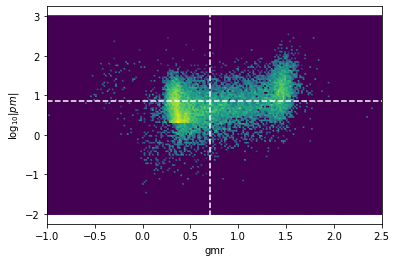

In [67]:
bright = rmag < 19
pl.hexbin(gmr[bright],np.log10(np.abs(pm[bright])),bins='log',extent=(-1,2.5,-2,3),gridsize=200)#,s=1,alpha=0.1)
pl.xlim(-1,2.5)
pl.xlabel('gmr')
pl.ylabel('$\log_{10}|pm|$')
pl.axvline(0.7,c='white',ls='--')
pl.axhline(np.log10(7),c='white',ls='--')

In [68]:
mws_sv_target = (d['SV1_MWS_TARGET'] > 0) & (d['SV1_MWS_TARGET'] != 999999)

Bright targets with usable spectra

In [86]:
bright = rmag < 19
speckok = spec_ok(d.rv)
print(specok.sum(),len(d.rv), specok.sum()/len(d.rv))
print((bright & specok).sum(),len(d.rv), (bright & specok).sum()/len(d.rv))

321609 827395 0.388700681053185
279868 827395 0.3382519836353858


<ipython-input-87-b93540f35f13>:1: RuntimeWarning: divide by zero encountered in log10
  pl.hexbin(gmr[bright & specok],np.log10(np.abs(pm[bright & specok])),bins='log',extent=(-1,2.5,-2,3),gridsize=200)#,s=1,alpha=0.1)


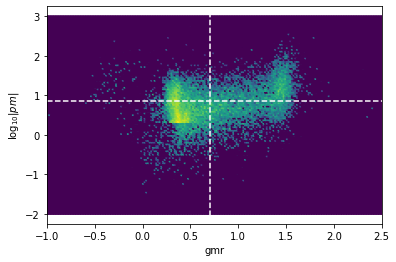

In [87]:
pl.hexbin(gmr[bright & specok],np.log10(np.abs(pm[bright & specok])),bins='log',extent=(-1,2.5,-2,3),gridsize=200)
pl.xlim(-1,2.5)
pl.xlabel('gmr')
pl.ylabel('$\log_{10}|pm|$')
pl.axvline(0.7,c='white',ls='--')
pl.axhline(np.log10(7),c='white',ls='--')

<ipython-input-205-3a28cf69403c>:2: RuntimeWarning: divide by zero encountered in log10
  pl.hexbin(gmr[bright & specok],np.log10(np.abs(pm[bright & specok])),


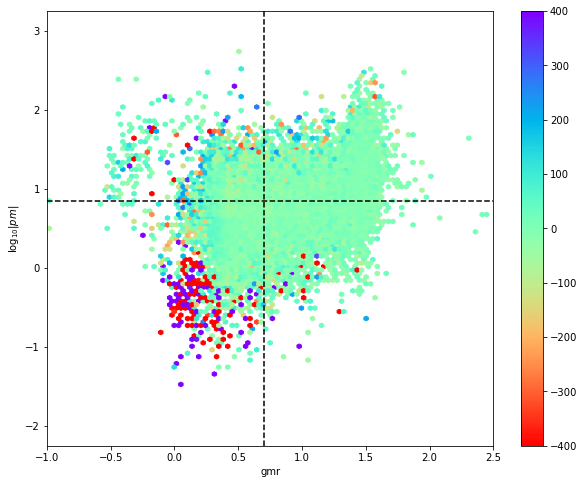

In [205]:
pl.figure(figsize=(10,8))
pl.hexbin(gmr[bright & specok],np.log10(np.abs(pm[bright & specok])),
          C=d.rv['VRAD'][bright & specok],vmax=400,vmin=-400,
          reduce_C_function=np.median,cmap='rainbow_r',
          extent=(-1,2.5,-2,3),gridsize=100)
pl.xlim(-1,2.5)
pl.xlabel('gmr')
pl.ylabel('$\log_{10}|pm|$')
pl.axvline(0.7,c='k',ls='--')
pl.axhline(np.log10(7),c='k',ls='--')
pl.colorbar()

<ipython-input-208-edcc90969437>:2: RuntimeWarning: divide by zero encountered in log10
  pl.hexbin(gmr[bright & specok],np.log10(np.abs(pm[bright & specok])),


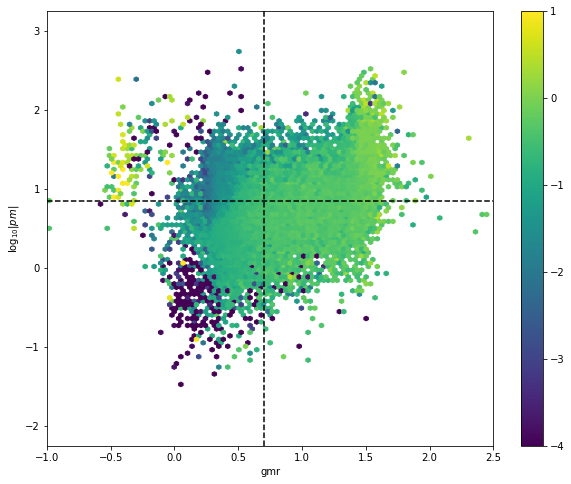

In [208]:
pl.figure(figsize=(10,8))
pl.hexbin(gmr[bright & specok],np.log10(np.abs(pm[bright & specok])),
          C=d.rv['FEH'][bright & specok],vmax=1,vmin=-4,
          reduce_C_function=np.median,
          extent=(-1,2.5,-2,3),gridsize=100)
pl.xlim(-1,2.5)
pl.xlabel('gmr')
pl.ylabel('$\log_{10}|pm|$')
pl.axvline(0.7,c='k',ls='--')
pl.axhline(np.log10(7),c='k',ls='--')
pl.colorbar()


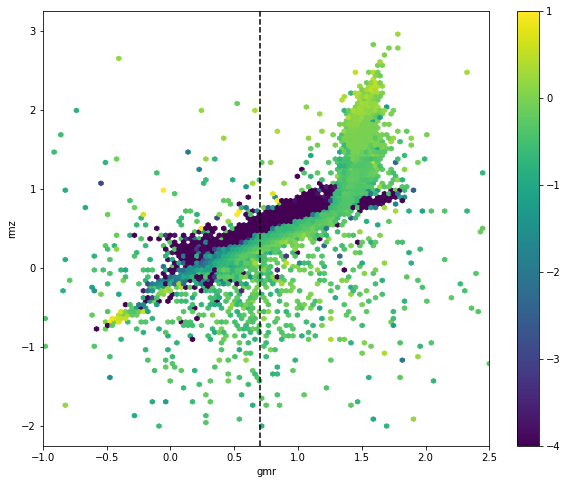

In [217]:
pl.figure(figsize=(10,8))
pl.hexbin(gmr[bright & specok],rmz[bright & specok],
          C=d.rv['FEH'][bright & specok],vmax=1,vmin=-4,
          reduce_C_function=np.median,
          extent=(-1,2.5,-2,3),gridsize=100)
pl.xlim(-1,2.5)
pl.xlabel('gmr')
pl.ylabel('rmz')
pl.axvline(0.7,c='k',ls='--')
pl.colorbar()

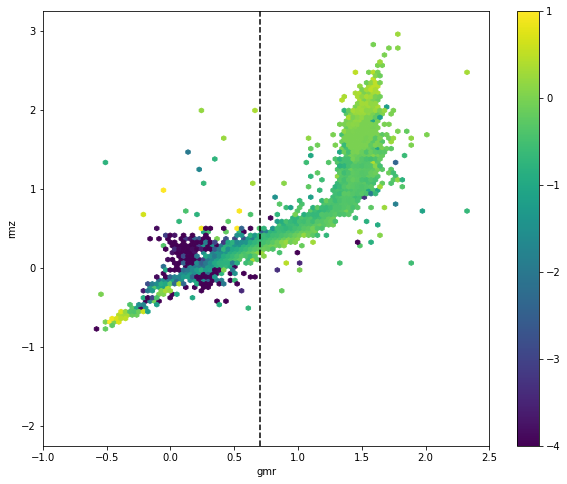

In [218]:
pl.figure(figsize=(10,8))
pl.hexbin(gmr[bright & specok & mws_sv_target],rmz[bright & specok & mws_sv_target],
          C=d.rv['FEH'][bright & specok & mws_sv_target],vmax=1,vmin=-4,
          reduce_C_function=np.median,
          extent=(-1,2.5,-2,3),gridsize=100)
pl.xlim(-1,2.5)
pl.xlabel('gmr')
pl.ylabel('rmz')
pl.axvline(0.7,c='k',ls='--')
pl.colorbar()


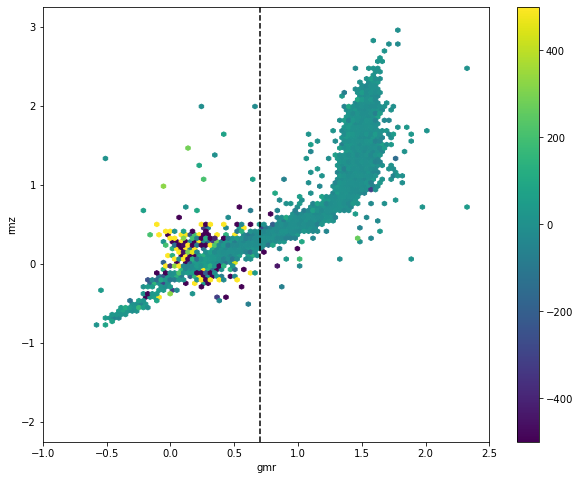

In [219]:
pl.figure(figsize=(10,8))
pl.hexbin(gmr[bright & specok & mws_sv_target],rmz[bright & specok & mws_sv_target],
          C=d.rv['VRAD'][bright & specok & mws_sv_target],vmax=500,vmin=-500,
          reduce_C_function=np.median,
          extent=(-1,2.5,-2,3),gridsize=100)
pl.xlim(-1,2.5)
pl.xlabel('gmr')
pl.ylabel('rmz')
pl.axvline(0.7,c='k',ls='--')
pl.colorbar()

In [221]:
is_mws_red,is_mws_blue,is_mws_broad = mws_samples(d)

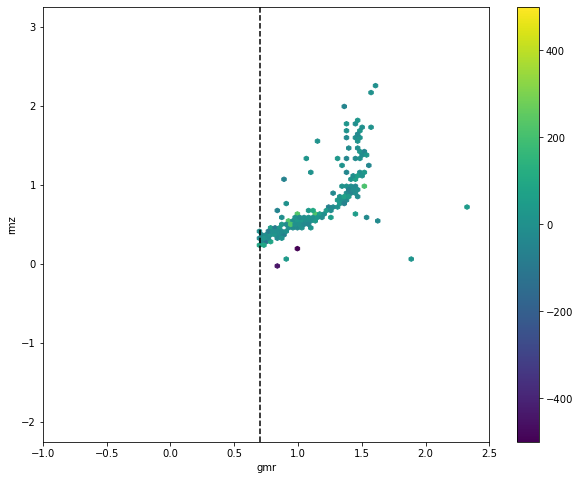

In [222]:
pl.figure(figsize=(10,8))
sel = bright & specok & mws_sv_target & is_mws_red
pl.hexbin(gmr[sel],rmz[sel],
          C=d.rv['VRAD'][sel],vmax=500,vmin=-500,
          reduce_C_function=np.median,
          extent=(-1,2.5,-2,3),gridsize=100)
pl.xlim(-1,2.5)
pl.xlabel('gmr')
pl.ylabel('rmz')
pl.axvline(0.7,c='k',ls='--')
pl.colorbar()

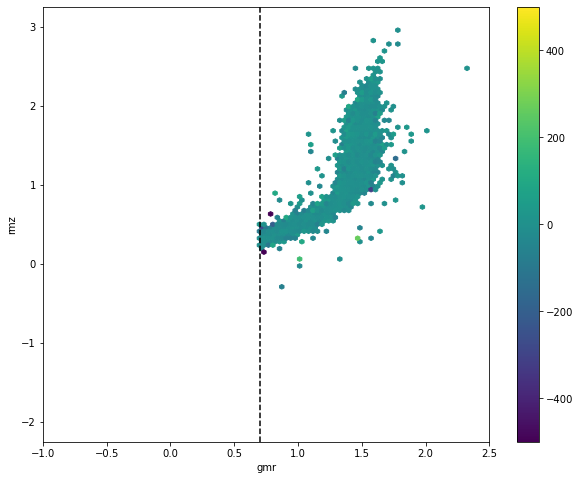

In [223]:
pl.figure(figsize=(10,8))
sel = bright & specok & mws_sv_target & is_mws_broad
pl.hexbin(gmr[sel],rmz[sel],
          C=d.rv['VRAD'][sel],vmax=500,vmin=-500,
          reduce_C_function=np.median,
          extent=(-1,2.5,-2,3),gridsize=100)
pl.xlim(-1,2.5)
pl.xlabel('gmr')
pl.ylabel('rmz')
pl.axvline(0.7,c='k',ls='--')
pl.colorbar()

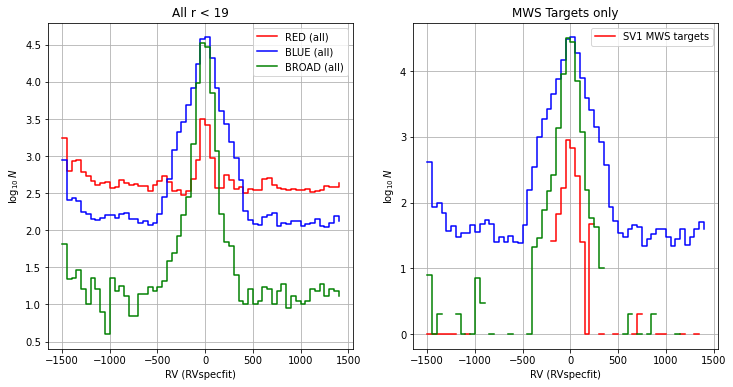

In [159]:
def decorate():
    pl.grid()
    pl.xlabel('RV (RVspecfit)')
    pl.ylabel('$\log_{10}\,N$')
    pl.legend()
    
plot_compare_mws_samples(d.rv['VRAD'],d,np.arange(-1500,1500,50),decorate=decorate)

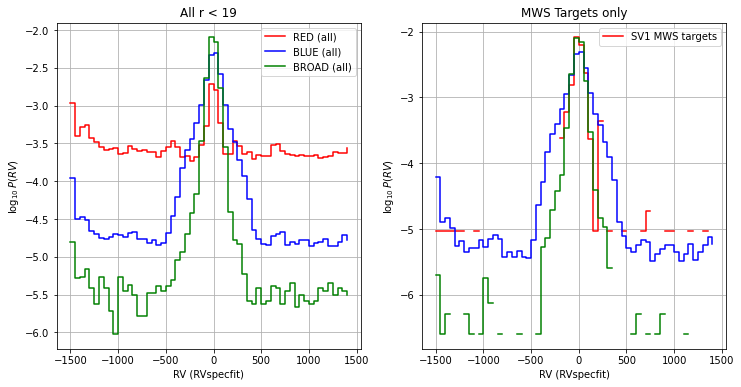

In [98]:
def decorate():
    pl.grid()
    pl.xlabel('RV (RVspecfit)')
    pl.ylabel('$\log_{10}\,P(RV)$')
    pl.legend()
    
plot_compare_mws_samples(d.rv['VRAD'],d,np.arange(-1500,1500,50),decorate=decorate,density=True)

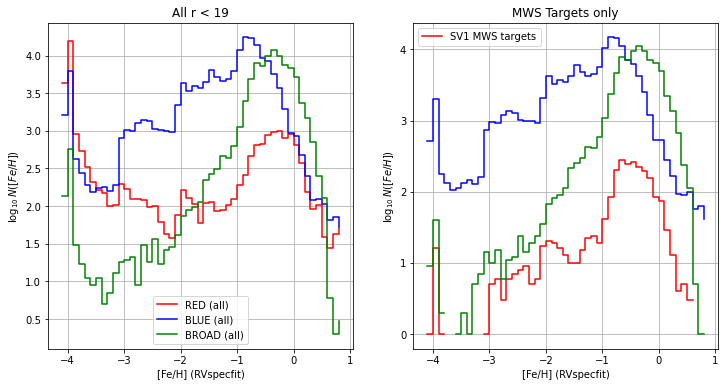

In [99]:
def decorate():
    pl.grid()
    pl.xlabel('[Fe/H] (RVspecfit)')
    pl.ylabel('$\log_{10}\,N([Fe/H])$')
    pl.legend()
    
plot_compare_mws_samples(d.rv['FEH'],d,np.arange(-5,1,0.1),decorate=decorate,density=False)

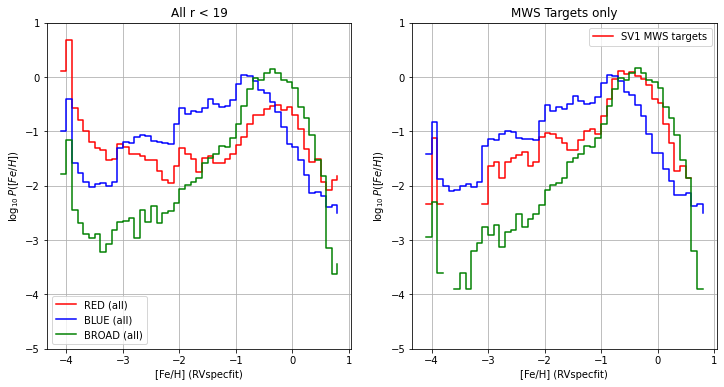

In [100]:
def decorate():
    pl.grid()
    pl.xlabel('[Fe/H] (RVspecfit)')
    pl.ylabel('$\log_{10}\,P([Fe/H])$')
    pl.legend()
    pl.ylim(-5,1)
    
plot_compare_mws_samples(d.rv['FEH'],d,np.arange(-5,1,0.1),decorate=decorate,density=True)

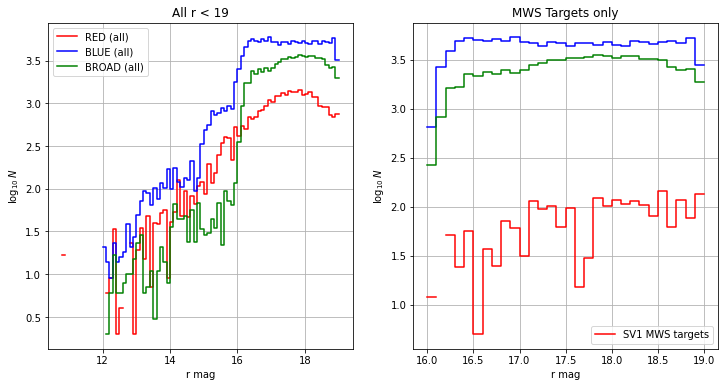

In [101]:
def decorate():
    pl.grid()
    pl.xlabel('r mag')
    pl.ylabel('$\log_{10}\,N$')
    pl.legend()
    
plot_compare_mws_samples(rmag,d,np.arange(10,22,0.1),decorate=decorate)

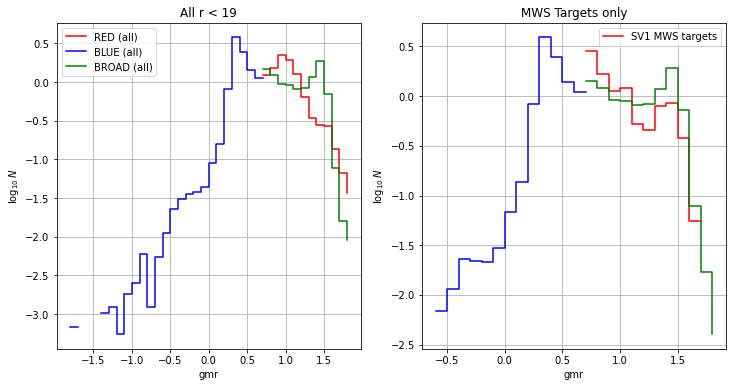

In [102]:
def decorate():
    pl.grid()
    pl.xlabel('gmr')
    pl.ylabel('$\log_{10}\,N$')
    pl.legend()
    
plot_compare_mws_samples(gmr,d,np.arange(-2,2,0.1),decorate=decorate,density=True)

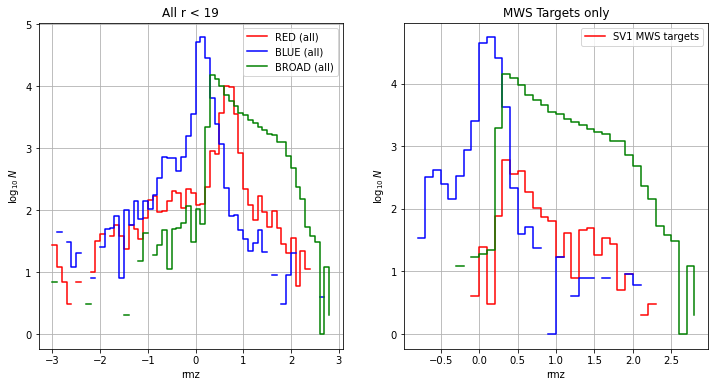

In [103]:
def decorate():
    pl.grid()
    pl.xlabel('rmz')
    pl.ylabel('$\log_{10}\,N$')
    pl.legend()
    
plot_compare_mws_samples(rmz,d,np.arange(-3,3,0.1),decorate=decorate,density=False)

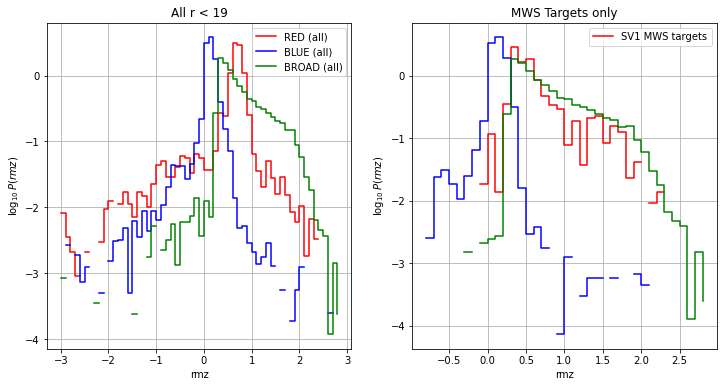

In [105]:
def decorate():
    pl.grid()
    pl.xlabel('rmz')
    pl.ylabel('$\log_{10}\,P(rmz)$')
    pl.legend()
    
plot_compare_mws_samples(rmz,d,np.arange(-3,3,0.1),decorate=decorate,density=True)

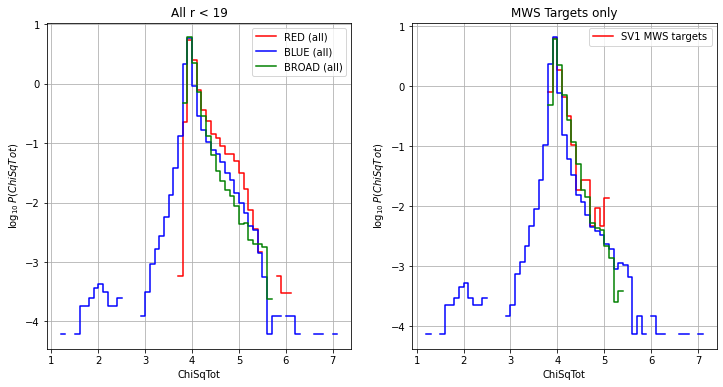

In [160]:
def decorate():
    pl.grid()
    pl.xlabel('ChiSqTot')
    pl.ylabel('$\log_{10}\,P(ChiSqTot)$')
    pl.legend()
plot_compare_mws_samples(np.log10(d.rv['CHISQ_TOT']),d,np.arange(1,10,0.1),decorate=decorate,density=True)

In [153]:
c = MWSCoadd(redux='blanc')
c

MWS: blanc-all (/global/cfs/cdirs/desi/science/mws/redux/blanc/mwtab_coadd-blanc-all.fits)

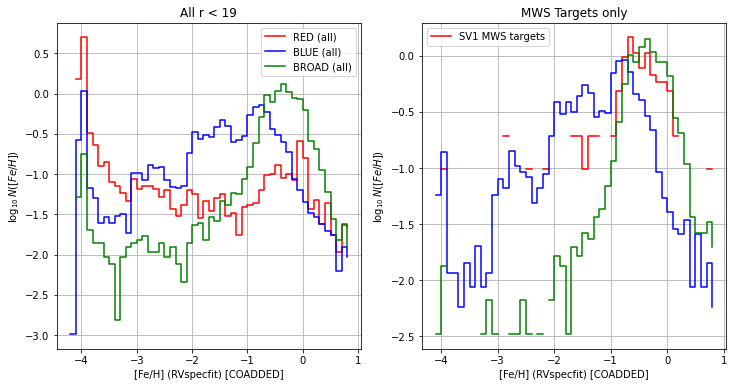

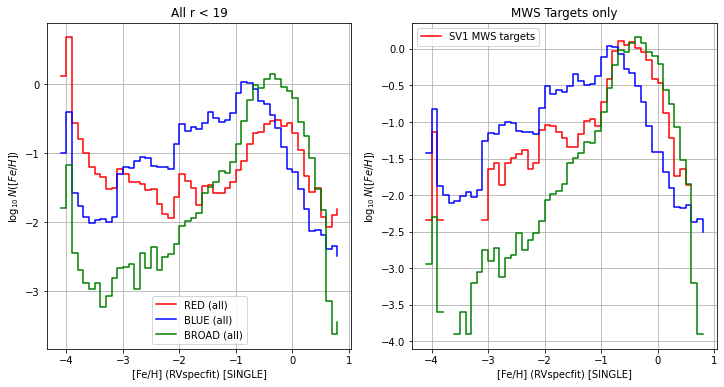

In [179]:
def decorate():
    pl.grid()
    pl.xlabel('[Fe/H] (RVspecfit) [COADDED]')
    pl.ylabel('$\log_{10}\,N([Fe/H])$')
    pl.legend()
    
plot_compare_mws_samples(c.rv['FEH_RV'],c,np.arange(-5,1,0.1),decorate=decorate,density=True,success='SUCCESS_RV')

def decorate():
    pl.grid()
    pl.xlabel('[Fe/H] (RVspecfit) [SINGLE]')
    pl.ylabel('$\log_{10}\,N([Fe/H])$')
    pl.legend()
    
plot_compare_mws_samples(d.rv['FEH'],d,np.arange(-5,1,0.1),decorate=decorate,density=True)

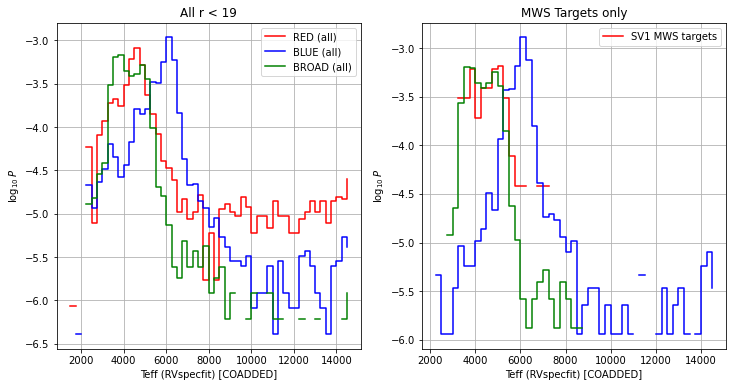

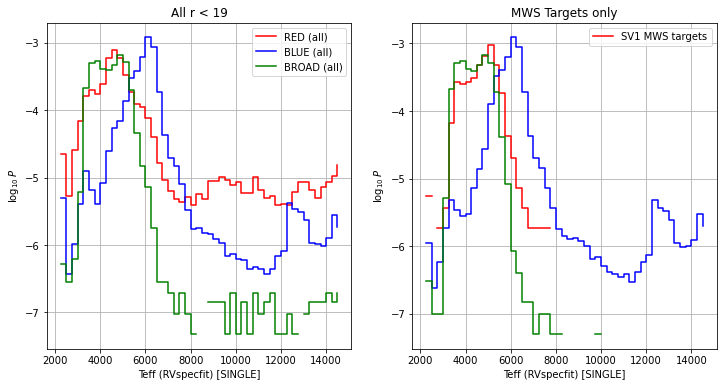

In [229]:
def decorate():
    pl.grid()
    pl.xlabel('Teff (RVspecfit) [COADDED]')
    pl.ylabel('$\log_{10}\,P$')
    pl.legend()
    
plot_compare_mws_samples(c.rv['TEFF_RV'],c,np.arange(0,15000,250),decorate=decorate,density=True,success='SUCCESS_RV')

def decorate():
    pl.grid()
    pl.xlabel('Teff (RVspecfit) [SINGLE]')
    pl.ylabel('$\log_{10}\,P$')
    pl.legend()
    
plot_compare_mws_samples(d.rv['TEFF'],d,np.arange(0,15000,250),decorate=decorate,density=True)

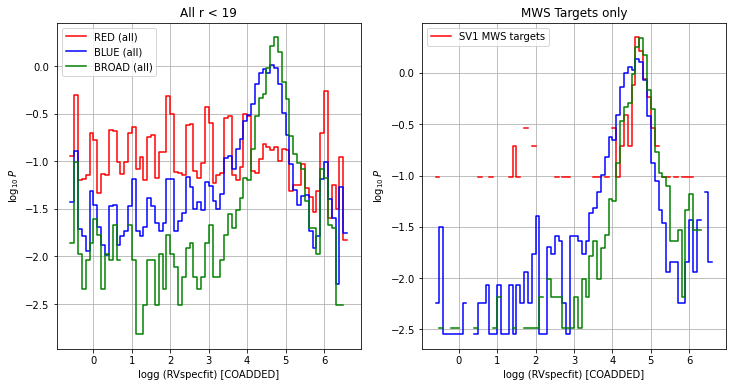

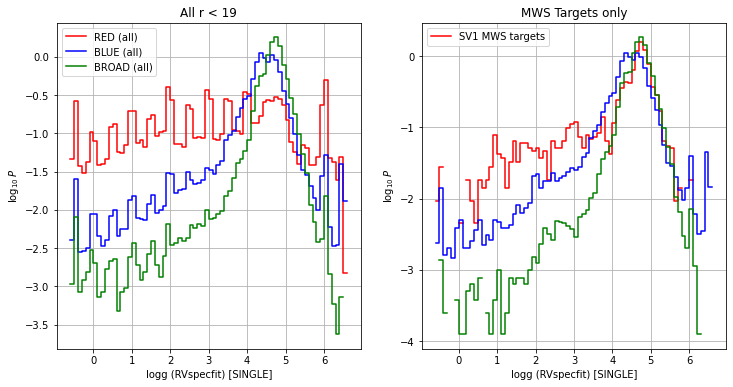

In [237]:
def decorate():
    pl.grid()
    pl.xlabel('logg (RVspecfit) [COADDED]')
    pl.ylabel('$\log_{10}\,P$')
    pl.legend()
    
plot_compare_mws_samples(c.rv['LOGG_RV'],c,np.arange(-1,7,0.1),decorate=decorate,density=True,success='SUCCESS_RV')

def decorate():
    pl.grid()
    pl.xlabel('logg (RVspecfit) [SINGLE]')
    pl.ylabel('$\log_{10}\,P$')
    pl.legend()
    
plot_compare_mws_samples(d.rv['LOGG'],d,np.arange(-1,7,0.1),decorate=decorate,density=True)

(8.0, -1.0)

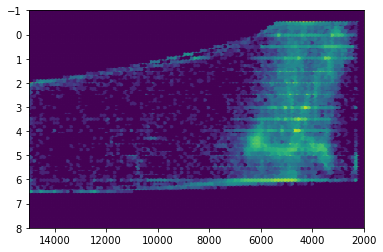

In [243]:
pl.hexbin(c.rv['TEFF_RV'],c.rv['LOGG_RV'],extent=(2000,15000,-1,8),bins='log')
pl.xlim(15000,2000)
pl.ylim(8,-1)

(8.0, -1.0)

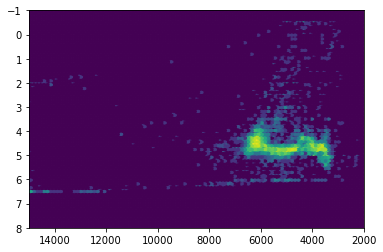

In [244]:
pl.hexbin(c.rv['TEFF_RV'][coadd_is_mws_target],c.rv['LOGG_RV'][coadd_is_mws_target],extent=(2000,15000,-1,8),bins='log')
pl.xlim(15000,2000)
pl.ylim(8,-1)

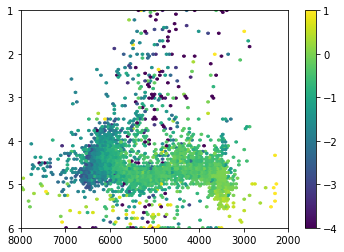

In [261]:
pl.hexbin(c.rv['TEFF_RV'][coadd_is_mws_target],c.rv['LOGG_RV'][coadd_is_mws_target],
          C=c.rv['FEH_RV'][coadd_is_mws_target],reduce_C_function=np.median,
          extent=(2000,8000,1,6),gridsize=100)
pl.xlim(8000,2000)
pl.ylim(6,1)
pl.colorbar()

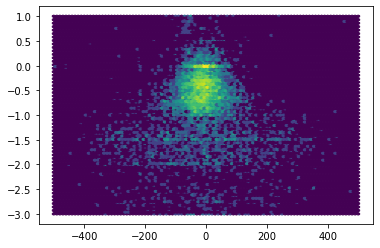

In [271]:
pl.hexbin(c.rv['VRAD'][coadd_is_mws_target],c.rv['FEH_RV'][coadd_is_mws_target],bins='log',extent=(-500,500,-3,1))

https://desi.lbl.gov/trac/wiki/SurveyValidation/SV1

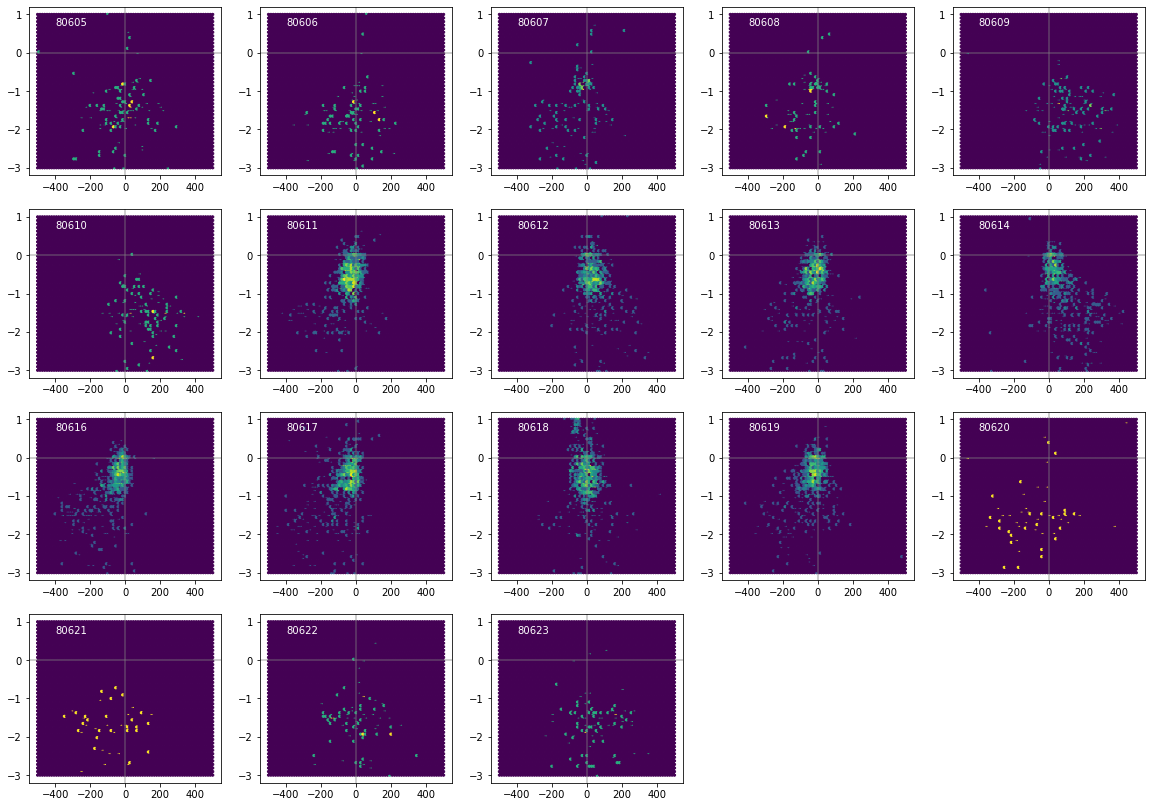

In [296]:
tileids = np.unique(c.fm['TILEID'][coadd_is_mws_target])
nplots = len(tileids)
nrow = int(np.ceil(np.sqrt(nplots)))

f = pl.figure(figsize=(20,18))

grid = gridspec.GridSpec(nrow,nrow)

for i,tileid in enumerate(tileids):
    f.add_subplot(grid[i])
    sel = (c.fm['TILEID'] == tileid) & coadd_is_mws_target
    pl.hexbin(c.rv['VRAD'][sel],
              c.rv['FEH_RV'][sel],
              gridsize=75,
              bins='log',extent=(-500,500,-3,1))
    pl.text(-400,0.7,tileid,fontsize=10,c='w')
    pl.axvline(0,c='grey',alpha=0.5)
    pl.axhline(0,c='grey',alpha=0.5)

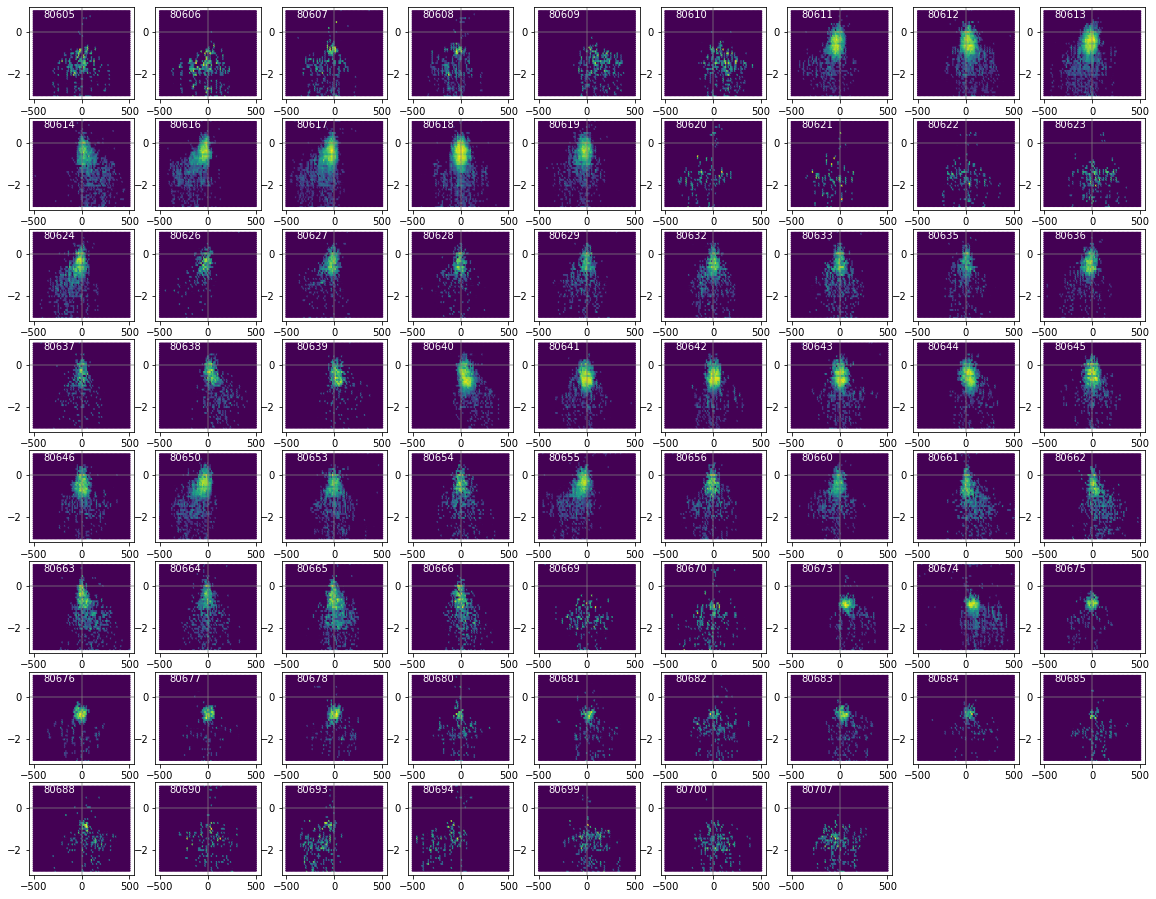

In [299]:
tileids = np.unique(d.fm['TILEID'][mws_sv_target & bright])
nplots = len(tileids)
nrow = int(np.ceil(np.sqrt(nplots)))

f = pl.figure(figsize=(20,18))

grid = gridspec.GridSpec(nrow,nrow)

for i,tileid in enumerate(tileids):
    f.add_subplot(grid[i])
    sel = (d.fm['TILEID'] == tileid) & mws_sv_target & bright
    pl.hexbin(d.rv['VRAD'][sel],
              d.rv['FEH'][sel],
              gridsize=75,
              bins='log',extent=(-500,500,-3,1))
    pl.text(-400,0.7,tileid,fontsize=10,c='w')
    pl.axvline(0,c='grey',alpha=0.5)
    pl.axhline(0,c='grey',alpha=0.5)

In [ ]:
pl.su

In [279]:
import matplotlib.gridspec as gridspec

In [183]:
coadd_is_mws_target = (c['SV1_MWS_TARGET'] > 0) & (c['SV1_MWS_TARGET'] != 999999)
sel = coadd_is_mws_target
Table(np.unique(c['TILEID'][sel],return_counts=True))

TILEID,col1
int32,int64
80605,169
80606,109
80607,178
80608,97
80609,172
80610,115
80611,776
80612,746
80613,783


In [ ]:
Table(np.unique(d['TILEID'][ ],return_counts=True))